In [120]:
import numpy as np
import h5py
import math
import pandas as pd
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os, sys
import random
import scipy
from PIL import Image
from PIL import ImageDraw
import time
import io

In [121]:
def save_cutImages(cut_indices, chunk_num):

            def make_box(mm_grid):
                """
                Draws the box for the energy bar
                """
                box_row = np.array([4, 4])
                to_box_row = np.array([145, 146])
                for_box_col = np.array([7, 17])

                box_col = np.array([7, 7])
                to_box_col = np.array([17, 17])
                for_box_row = np.array([4, 145])

                # Draw vertical lines of energy bar box
                for i in range(len(box_row)):
                    mm_grid[box_row[i]:to_box_row[i], for_box_col[i], :] = 0
                    mm_grid[for_box_row[i], box_col[i]:to_box_col[i], :] = 0

                return mm_grid


            def make_grid():
                """
                "Create Training Data.ipynb"eate grid matrix of MM outline and energy bar, see spreadsheet below
                https://docs.google.com/spreadsheets/d/1_bbg6svfEph_g_Z002rmzTLu8yjQzuj_p50wqs7mMrI/edit?usp=sharing
                """
                row = np.array([63, 47, 39, 31, 27, 23, 19, 15, 15, 11, 11, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 7, 7, 
                        7, 7, 11, 11, 15, 15, 19, 23, 27, 31, 39, 47, 63]) 

                to_row = np.array([87, 103, 111, 119, 123, 127, 131, 135, 135, 139, 139, 143, 143, 143, 143, 147, 
                           147, 147, 147, 147, 147, 148, 143, 143, 143, 144, 139, 140, 135, 136, 132, 128,
                           124, 120, 112, 104, 88]) 

                col = np.array([100, 84, 76, 68, 64, 60, 56, 52, 52, 48, 48, 44, 44, 44, 44, 40, 40, 40, 40, 40, 
                        40, 40, 44, 44, 44, 44, 48, 48, 52, 52, 56, 60, 64, 68, 76, 84, 100])

                to_col = np.array([124, 140, 148, 156, 160, 164, 168, 172, 172, 176, 176, 180, 180, 180, 180, 184, 
                           184, 184, 184, 184, 184, 184, 180, 180, 180, 180, 176, 176, 172, 172, 168, 164, 
                           160, 156, 148, 140, 124]) 

                all_row = np.array([i for i in range(3, 148, 4)])
                all_col = np.array([i for i in range(40, 185, 4)]) 

                full_image_size_width = 224
                full_image_size_length = 151
                mm_grid = np.zeros((full_image_size_length, full_image_size_width, 3))    
                mm_grid.fill(255)                                                     

                for i in range(len(row)):
                    # draw grid columns, 0 = black
                    mm_grid[row[i]:to_row[i], all_col[i], :] = 0
            
                for i in range(len(col)):
                    # draw grid rows
                    mm_grid[all_row[i], col[i]:to_col[i], :] = 0

                # Ensure that matrix is of integers
                mm_grid = mm_grid.astype(int) 

                # Draw engergy bar box
                mm_grid = make_box(mm_grid)

                return mm_grid

            # Precompute the grid once and reuse it
            global_grid = make_grid()


            def blue_range(pad_plane, rows):

                start_row = 140
                low_color = 0
                high_color = 35

                for i in range(rows):
                    pad_plane[start_row:start_row+5, 8:17, 0] = low_color
                    pad_plane[start_row:start_row+5, 8:17, 1] = high_color
                    start_row = start_row - 5 
                    low_color = low_color + 35
                    high_color = high_color + 35

                return pad_plane


            def yellow_range(pad_plane, rows):

                start_row = 105
                color = 220

                for i in range(rows):
                    pad_plane[start_row:start_row+5, 8:17, 2] = color
                    start_row = start_row - 5 
                    color = color - 15

                return pad_plane


            def orange_range(pad_plane, rows):

                start_row = 70
                color = 210
                for i in range(rows):
                    pad_plane[start_row:start_row+5, 8:17, 1] = color - 15
                    pad_plane[start_row:start_row+5, 8:17, 2] = color
                    start_row = start_row - 5 
                    color = color - 15

                return pad_plane


            def red_range(pad_plane, rows):

                start_row = 35
                color = 250

                for i in range(rows):
                    pad_plane[start_row:start_row+5, 8:17, 0] = color
                    pad_plane[start_row:start_row+5, 8:17, 1] = 50
                    pad_plane[start_row:start_row+5, 8:17, 2] = 50
                    start_row = start_row - 5 
                    color = color - 15

                return pad_plane


            def tot_energy_to_mev(tot_energy):
                tot_energy = tot_energy / 1000
                return tot_energy


            def fill_energy_bar(pad_plane, tot_energy):
                """
                Fills the energy bar where the amount of pixels fired and the color corresponds to the energy of the track
                Max pixel_range should be 28 (7 rows for each color), so need to adjust accordingly.
                """
                # Calculate the energy in MeV
                energy_mev = tot_energy_to_mev(tot_energy)

                # Calculate the proportion of the energy bar that should be filled
                proportion_filled = energy_mev / 3

                # Calculate how many rows should be filled
                total_rows = math.floor(proportion_filled * 28)

                # Fill the energy bar one row at a time
                if total_rows > 0:
                    pad_plane = blue_range(pad_plane, rows=min(total_rows, 7))
                if total_rows > 7:
                    pad_plane = yellow_range(pad_plane, rows=min(total_rows-7, 7))
                if total_rows > 14:
                    pad_plane = orange_range(pad_plane, rows=min(total_rows-14, 7))
                if total_rows > 21:
                    pad_plane = red_range(pad_plane, rows=min(total_rows-21, 7))

                return pad_plane


            def pos_odd_even(event_value):
                """
                Makes correction to positive points if they are odd or even
                """
                if event_value % 2 == 0:
                    event_value = event_value + 1
                    return event_value

                else:
                    return event_value


            def neg_odd_even(event_value):
                """
                Makes correction to negative points if they are odd or even
                """
                if event_value % 2 == 0:
                    event_value = event_value - 1
                    return event_value

                else:
                    return event_value


            def pt_shift(xset, yset):
                """
                Shifts all points to the center of nearest pad for pad mapping
                """
                for j in range(len(xset)):

                    if xset[j] > 0:
                        xset[j] = math.floor(xset[j])
                        pos_adj_valx = pos_odd_even(xset[j])
                        xset[j] = pos_adj_valx

                    elif xset[j] < 0:
                        xset[j] = math.ceil(xset[j])
                        neg_adj_valx = neg_odd_even(xset[j])
                        xset[j] = neg_adj_valx

                    if yset[j] > 0:
                        yset[j] = math.floor(yset[j])
                        pos_adj_valy = pos_odd_even(yset[j])
                        yset[j] = pos_adj_valy

                    elif yset[j] < 0:
                        yset[j] = math.ceil(yset[j])
                        neg_adj_valy = neg_odd_even(yset[j])
                        yset[j] = neg_adj_valy

                return xset, yset

            def hsv_to_rgb(hsv):
                h, s, v = 360*hsv[:, 0], hsv[:, 1], hsv[:, 2]
                c = s * v
                x = c * (1 - np.abs((h / 60) % 2 - 1))
                m = v - c

                i = (h // 60).astype(int)

                r = np.choose(i, [c, x, 0, 0, x, c], mode='clip') + m
                g = np.choose(i, [x, c, c, x, 0, 0], mode='clip') + m
                b = np.choose(i, [0, 0, x, c, c, x], mode='clip') + m

                return np.stack([r, g, b], axis=1)
            
            def fill_padplane(xset, yset, tset, eset, tot_energy, global_grid):
                """
                Fills the 2D pad plane grid for image creation
                """
                pad_plane = np.copy(global_grid)

                xset = np.array(xset)
                yset = np.array(yset)
                eset = np.array(eset)
                tset = np.array(tset)

                # pad plane mapping
                x = (35 + xset) * 2 + 42    # col value
                y = 145 - (35 + yset) * 2   # row value

                # create a dictionary to store (x,y) as keys and Energy Signal as values
                Es = {}; Ts = {}
                for i in range(len(x)):
                    key = (x[i], y[i])
                    if key in Es:
                        Es[key].append(eset[i])
                        Ts[key].append(tset[i])
                    else:
                        Es[key] = [eset[i]]
                        Ts[key] = [tset[i]]
                
                # convert the dictionary back to arrays
                x = np.zeros(len(Es))
                y = np.zeros(len(Es))
                pad_colors = np.zeros((len(Es),3)) # color array
                
                for i, key in enumerate(Es):
                    int_charge = np.sum(Es[key]) # current method, int charge on pad
                    if int_charge > 100: # threshold in post
                        x[i] = key[0]
                        y[i] = key[1]
                        
                        pad_colors[i,0] = Ts[key][np.argmax(Es[key])]

                        pad_colors[i,1] = 1 # int_charge
                        pad_colors[i,2] = int_charge
                        
                #print(np.max(pad_colors[:,0]))
                
                def norm_by_max(array):
                    return np.clip(array / np.max(array), 0, 1)
                def norm_by_minmax(array):
                    min_array = np.min(array[np.nonzero(array)])
                    
                    return (array - min_array) / (np.max(array) - min_array)
                
                
                pad_colors[:,0] = norm_by_minmax(pad_colors[:,0]) * 0.7 # normalize ch0
                pad_colors[:,1] = norm_by_max(pad_colors[:,1]) # normalize ch1
                pad_colors[:,2] = norm_by_max(pad_colors[:,2]) # normalize ch2
                
                
                pad_colors = hsv_to_rgb(pad_colors) # HSV to RGB conversion
                
                pad_colors = pad_colors * 255
                
                # Fill in pad plane   
                for k in range(len(x)):
                
                    if y[k] < 9:
                        y[k] = y[k] + 4

                    if x[k] < 50:
                        x[k] = x[k] + 4

                    if x[k] > 174:
                        x[k] = x[k] - 4

                    if y[k] > 53:
                        y[k] = y[k] - 4

                    if x[k] > 134:
                        x[k] = x[k] - 4

                    if y[k] > 93:
                        y[k] = y[k] - 4

                    if y[k] > 133:
                        y[k] = y[k] - 4	

                    if x[k] < 90:
                        x[k] = x[k] + 4

                    yoff = 4
                    xoff = 0
                    
                    # Color Padplane
                    pad_plane[int(y[k])-1+yoff:int(y[k])+2+yoff, int(x[k])-1+xoff:int(x[k])+2+xoff, :] = pad_colors[k,:]

                pad_plane = fill_energy_bar(pad_plane, tot_energy)

                return pad_plane

            def drop_zeros(array):
                last_nonzero = np.max(np.nonzero(array))
                return array[:last_nonzero+1]
            
            def form_trace(eHit, tHit):
                """
                Forms the trace of the particle track
                """
                trace = np.zeros(512)
                for i in range(len(eHit)):
                    trace[tHit[i]] = eHit[i]
                return trace
            
            def plot_track(cut_indices):
                import pickle
                all_image_data = []  # List to store the results
                xHit_list = np.load(os.path.join(automation_dir, 'Output/xHit_list.npy'), allow_pickle=True)
                yHit_list = np.load(os.path.join(automation_dir, 'Output/yHit_list.npy'), allow_pickle=True)
                tHit_list = np.load(os.path.join(automation_dir, 'Output/tHit_list.npy'), allow_pickle=True)
                eHit_list = np.load(os.path.join(automation_dir, 'Output/eHit_list.npy'), allow_pickle=True)
                trace_list = np.load(os.path.join(automation_dir, 'Output/trace_list.npy'), allow_pickle=True)
                tot_energy = np.load(os.path.join(automation_dir, 'Output/tot_energy.npy'), allow_pickle=True)
    
                for event_num in cut_indices:
                    xHit = xHit_list[event_num]
                    yHit = yHit_list[event_num]
                    tHit = tHit_list[event_num]
                    eHit = eHit_list[event_num]
                    energy = tot_energy[event_num]
     
                    # Call pt_shift function to move all 2D pts to pad centers
                    dset_0_copyx, dset_0_copyy = pt_shift(xHit, yHit)

                    # Call fill_padplane to create 2D pad plane image
                    pad_plane = fill_padplane(dset_0_copyx, dset_0_copyy, tHit, eHit, energy, global_grid)
                    
                    trace = trace_list[event_num]
                    
                    # Prepare the data necessary for plotting
                    image_title = f' Image {cut_indices[event_num-1]} of Particle Track Event'
                    image_filename = f"{sim_name}_image_{event_num}.png"

                    all_image_data.append((pad_plane, trace, image_title, image_filename))  # Append the result to the list

                del xHit_list 
                del yHit_list 
                del eHit_list

                return all_image_data  # Return the list of all results after the loop


            result = plot_track(cut_indices)
            return result

In [122]:
def clean_trace(data_trace): 
    trace = data_trace
    max_val = np.argmax(trace)
    low_bound = max_val - 75
    if low_bound < 0:
	    low_bound = 5
    upper_bound = max_val + 75
    if upper_bound > 511:
        upper_bound = 506
    trace = trace[low_bound:upper_bound]
    return trace

In [123]:
# CREATE IMAGES FROM HDF5 FILE
sim_name = 'TestPP'
automation_dir = '/mnt/analysis/e17023/Adam/GAPA/'
h5file = h5py.File(automation_dir + "Output/hdf5/" + sim_name + '.h5', 'r')

xHit_list = []; yHit_list = []; eHit_list = []; tHit_list = []; trace_list = []; tot_energy = []; cut_indices = []
for i in h5file.keys():
    xHit_list.append(h5file[i]['HitArray']['x'])
    yHit_list.append(h5file[i]['HitArray']['y'])
    tHit_list.append(h5file[i]['HitArray']['t'])
    eHit_list.append(h5file[i]['HitArray']['A'])
    
    trace_list.append(clean_trace(h5file[i]['Trace']))
    tot_energy.append(h5file[i]['HitArray']['A'].sum())    
    if len(trace_list[-1]) > 2:
        cut_indices.append(int(i.split("[")[1].split("]")[0]))

xHit_list = np.array(xHit_list, dtype=object)
yHit_list = np.array(yHit_list, dtype=object)
eHit_list = np.array(eHit_list, dtype=object)
tHit_list = np.array(tHit_list, dtype=object)
trace_list = np.array(trace_list, dtype=object)
tot_energy = np.array(tot_energy)
cut_indices = np.array(cut_indices)

np.save(automation_dir + 'Output/xHit_list.npy', xHit_list)
np.save(automation_dir + 'Output/yHit_list.npy', yHit_list)
np.save(automation_dir + 'Output/eHit_list.npy', eHit_list)
np.save(automation_dir + 'Output/tHit_list.npy', tHit_list)
np.save(automation_dir + 'Output/trace_list.npy', trace_list)
np.save(automation_dir + 'Output/tot_energy.npy', tot_energy)

h5file.close()

In [124]:
circle_mask = np.ones((224, 224, 4), dtype=bool)
for i in range(circle_mask.shape[0]):
    for j in range(circle_mask.shape[1]):
        if (i-75)**2+(j-112)**2 <= 66.709**2:
            circle_mask[i,j,:] = [False,False,False,False]

In [125]:
def veto_check(image,circle_mask=circle_mask):
    # apply mask to image
    
    masked_image = image * circle_mask
    padplane = masked_image[0:151,37:188,0] # padplane region

    padplane[np.where(padplane==255)] = 0 # remove white
    
    veto = np.any(padplane != 0) # check for nonzero values
    return veto

In [126]:
def get_trace(chunk_indices):
    tHit_list = np.load(automation_dir + 'Output/tHit_list.npy', allow_pickle=True)
    eHit_list = np.load(automation_dir + 'Output/eHit_list.npy', allow_pickle=True)
    traces = []
    for i in chunk_indices:
        traces.append(trace_list[i])
    return traces

In [127]:
# Process images in chunks to avoiding overloading memory
chunk_size = 500
num_images = len(cut_indices)
#print("Total Number of Image:", num_images)
num_chunks = (num_images + chunk_size - 1) // chunk_size
#print("Total Number of Chunks:", num_chunks)
chunk_num = 1
for chunk_idx in range(num_chunks):
    #print(f"Processing Chunk {chunk_idx+1} of {num_chunks}")
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, num_images)
    chunk_indices = cut_indices[start_idx:end_idx]
    image_data = save_cutImages(chunk_indices, chunk_num)
    my_dpi = 96
    fig_size = (224/my_dpi, 73/my_dpi)  # Fig size to be used in the main thread
    fig, ax = plt.subplots(figsize=fig_size)
    ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Plot and save images in the main thread
    for pad_plane, trace, title, filename in image_data:
        # Plot trace
        ax.clear()
        trace = np.nan_to_num(trace.astype(float))
        x = np.linspace(0, len(trace)-1, len(trace))
        ax.fill_between(x, trace, color='b', alpha=1)
        
        # Assuming pad_plane is a NumPy array with shape (height, width, 3)
        alpha_channel = np.ones((pad_plane.shape[0], pad_plane.shape[1], 1), dtype=pad_plane.dtype) * 255
        pad_plane_rgba = np.concatenate((pad_plane, alpha_channel), axis=2)
        
        # Now pad_plane_rgba has an additional alpha channel and can be concatenated with trace_img
        # Ensure trace image is saved as PNG and read it
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=my_dpi)
        buf.seek(0)
        with Image.open(buf) as im:
            trace_img_png = np.array(im)
        buf.close()
        # Concatenate pad_plane_rgba and trace_img_png
        complete_image = np.append(pad_plane_rgba, trace_img_png, axis=0)
        # Convert image data to uint8 if it's not already
        if complete_image.dtype != np.uint8:
            if complete_image.max() > 1:
                complete_image = complete_image.astype(np.uint8)
            else:
                complete_image = (255 * complete_image).astype(np.uint8)

        plt.imsave(os.path.join(automation_dir+"Output/images/", filename), complete_image)
        # Close the figure to free memory
        plt.close(fig)
    chunk_num += 1

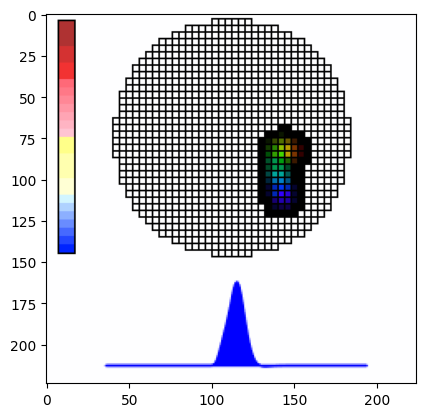

In [128]:
frames = []
output_files = list(os.listdir(automation_dir + "Output/images/"))
for i in range(min(len(output_files), 200)):
    new_frame = Image.open(automation_dir + "Output/images/" + output_files[i])
    frames.append(new_frame)

frames[0].save(f"{automation_dir}Output/test.gif", format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=900, loop=0)

img = Image.open(f"{automation_dir}Output/test.gif")
plt.imshow(img)